# Operation Analytics Project
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

    * Customers who left within the last month – the column is called Churn
    * Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    * Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    * Demographic info about customers – gender, age range, and if they have partners and dependents

Main task: Create a machine learning model to predict customers who will churn. Analyze important feature that lead to this behaviour.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('../WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Most of the features are of object data type, only some are of numerical data type.

In [55]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [56]:
#changing the Churn value to binary: 1:churn, 0:no churn
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

#dropping the customer ID because its not usefule for our analysis
df.drop(['customerID'], axis=1, inplace=True)

#Totalcharges is a string, so we need to convert it to float also there is values like '' which we need to drop
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [57]:
#Split the data into train and test with 80:20 split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2,stratify=df['Churn'])
train.shape, test.shape

((5634, 20), (1409, 20))

In [58]:
get_object_vars = [i for i in train.columns if train[i].dtype == 'object'] #getting the object columns
get_int_vars = [i for i in train.columns if train[i].dtype != 'object'] #getting the numerical columns

# EDA

Analysing the churn column

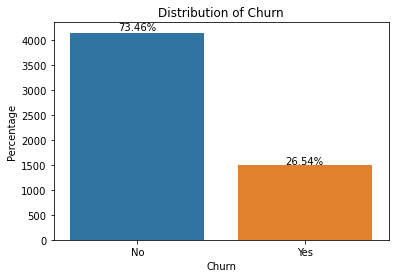

In [59]:
#create a bar graph to see the distribution of the y_train with percentage
ax = sns.countplot(y_train, label='Percentage')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.xticks(rotation=0,labels=['No','Yes'],ticks=[0,1])

#display percentage above bar chart
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height*100/y_train.shape[0]:.2f}%', (x + width/2, y + height*1.01), ha='center')
plt.show()

This is a highle imbalanced dataset with 26% of the customers churning.

In [60]:
def show_categorical_distribution(column, labels = []):
    """
    This function is used to show the distribution of categorical variables with
    percentage of each category
    """
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=column, data=train)
    plt.title(column)
    #display percentage above bar chart
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height*100/y_train.shape[0]:.2f}%', (x + width/2, y + height*1.01), ha='center')
    if labels:
        ax.set_xticklabels(labels)
    plt.show()

# Feature Selection for categorical data

In [61]:
def get_significant_categorical(
    data = train,
    target = 'Churn',
    columns = get_object_vars,
    threshold = 0.05,
    ):
    """
    This function returns all the categorical columns which have significant difference with target column unique values using
    Chi-squared test and also those columns which are not significant
    """
    significant = np.array([])
    non_significant = np.array([])
    for col in columns:
        chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[col], data[target]))
        if p < threshold:
            significant = np.append(significant, col)
        else:
            non_significant = np.append(non_significant, col)

    return significant, non_significant

In [62]:
significant, non_significant = get_significant_categorical(train, 'Churn', get_object_vars)

print('Significant columns:', *significant)

print('Non-significant columns:', *non_significant)

Significant columns: Partner Dependents MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod
Non-significant columns: gender PhoneService


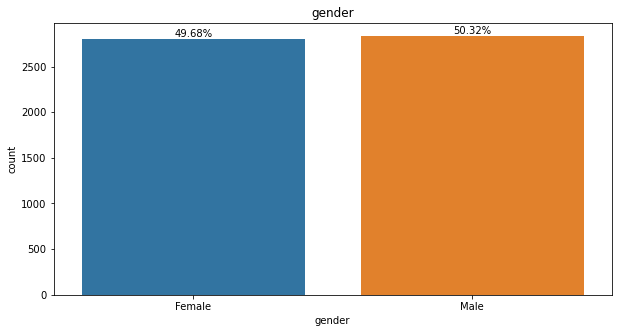

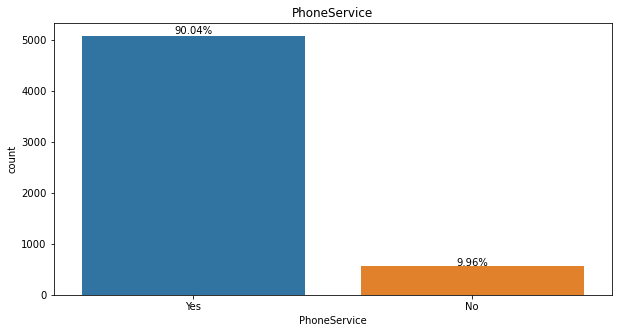

In [63]:
for col in non_significant:
    show_categorical_distribution(col)

'gender' & 'PhoneService' is not having significant difference between the churn unique values using Chi-squared test of indepedence. Hence we will remove these features 

In [50]:
train.drop(non_significant, axis=1, inplace=True)
test.drop(non_significant, axis=1, inplace=True)

In [ ]:
x_train = train.drop(['Churn'], axis=1)
y_train = train['Churn']

x_test = test.drop(['Churn'], axis=1)
y_test = test['Churn']